In [14]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l



In [15]:
#根据带有噪声的线性模型构造一个人造数据集。
#我们使用线性模型参数w=[2,-3.4]T、b=4.2和噪声项e生成数据集及其标签
#y=Xw+b+e

def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    #均值为0，标准差为1，行数是num_examples，列数是len(w)
    y = torch.matmul(X, w) + b
    #可多维的矩阵乘法
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))#-1表示任意行数

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
#features中的每一行都包含一个二维数据样本，分别对应w的两维
#labels中的每一行都包含一维标签值，对应每一个特征

In [16]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.6334, -0.1979]) 
label: tensor([6.1446])


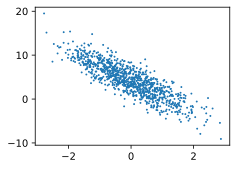

In [17]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [18]:
#定义一个data_iter函数
#用来接收批量大小、特征矩阵和标签向量作为输入
#生成大小为batch_size的小批量

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) #把下标完全打乱

    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        #每次取出打乱后下标的batch_size个
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.9153,  0.6650],
        [ 0.7603, -0.3108],
        [-0.0751,  0.4900],
        [-0.3283, -0.1686],
        [-0.4597,  0.7629],
        [-2.3023,  0.9307],
        [ 0.1016,  0.6945],
        [ 0.7687, -0.6795],
        [-0.9797, -0.2256],
        [-1.1551,  1.8756]]) 
 tensor([[ 0.0989],
        [ 6.7596],
        [ 2.3948],
        [ 4.1111],
        [ 0.6748],
        [-3.5719],
        [ 2.0509],
        [ 8.0343],
        [ 2.9981],
        [-4.4900]])


In [19]:


##定义模型 
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [20]:
#定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [21]:
#定义优化算法  sgd(Stochastic gradient descent)随机梯度下降
def sgd(params, lr, batch_size): ##params是参数   lr(learning rate)学习率即步长  
    """小批量随机梯度下降"""
    with torch.no_grad(): ##强制把此模块下得到的参数的requires_grad变成false，即反向传播的时候不会求梯度
        for param in params:
            param -= lr * param.grad / batch_size 
            param.grad.zero_()

In [22]:
#########
#训练过程#
#########

# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)

        #很显然l是一个（batch_size，1）的张量，表示我们随机出来的参数在这个点处得到的y_hat
        
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038479
epoch 2, loss 0.000140
epoch 3, loss 0.000052


In [23]:
## 查看学习到的与真实的之间的差距

print(f'w的估算误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估算误差: {true_b - b}')

w的估算误差: tensor([ 3.0029e-04, -8.2254e-05], grad_fn=<SubBackward0>)
b的估算误差: tensor([-0.0004], grad_fn=<RsubBackward1>)
